In [222]:
from SBN import SpectralBillinearNet,SpectralBilinearLayer
from DSN import DeepSpectralNet,SpectralQuadraticLayer
from Tool import fit
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

In [3]:
X = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
], dtype=np.float32)

# Labels XOR
y = np.array([
    0,
    1,
    1,
    0
], dtype=np.float32)
X_tensor = torch.from_numpy(X)
y_tensor = torch.from_numpy(y).unsqueeze(1)  # shape (4,1) pour la sortie

# Dataset et DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Vérification
for xb, yb in dataloader:
    print("Batch X:\n", xb)
    print("Batch y:\n", yb)

Batch X:
 tensor([[1., 0.],
        [0., 1.],
        [0., 0.],
        [1., 1.]])
Batch y:
 tensor([[1.],
        [1.],
        [0.],
        [0.]])


In [4]:
sbn = SpectralBillinearNet([2,1])
sbn.num_parameters

15

In [5]:
loss = nn.BCEWithLogitsLoss() 
model = fit(sbn,X_tensor,y_tensor,loss_function=loss)


Epoch 1/100 | Loss: 0.693026
Epoch 10/100 | Loss: 0.684614
Epoch 20/100 | Loss: 0.667216
Epoch 30/100 | Loss: 0.637733
Epoch 40/100 | Loss: 0.591350
Epoch 50/100 | Loss: 0.522960
Epoch 60/100 | Loss: 0.430218
Epoch 70/100 | Loss: 0.320927
Epoch 80/100 | Loss: 0.214182
Epoch 90/100 | Loss: 0.129691
Epoch 100/100 | Loss: 0.075248


In [8]:
head = sbn.layers[-1]
for name, param in head.named_parameters():
    print(f"{name} : {param.shape}")
print("U :", head.right_projections.weight)
print("U :", head.left_projections.weight)
print("λ :", head.eigen_weights.weight)

right_projections.weight : torch.Size([2, 2])
right_projections.bias : torch.Size([2])
left_projections.weight : torch.Size([2, 2])
left_projections.bias : torch.Size([2])
eigen_weights.weight : torch.Size([1, 2])
eigen_weights.bias : torch.Size([1])
U : Parameter containing:
tensor([[-1.5872,  0.9570],
        [ 1.7783,  1.7398]], requires_grad=True)
U : Parameter containing:
tensor([[-0.9644,  1.5671],
        [-1.5106, -1.5936]], requires_grad=True)
λ : Parameter containing:
tensor([[1.3503, 1.1079]], requires_grad=True)


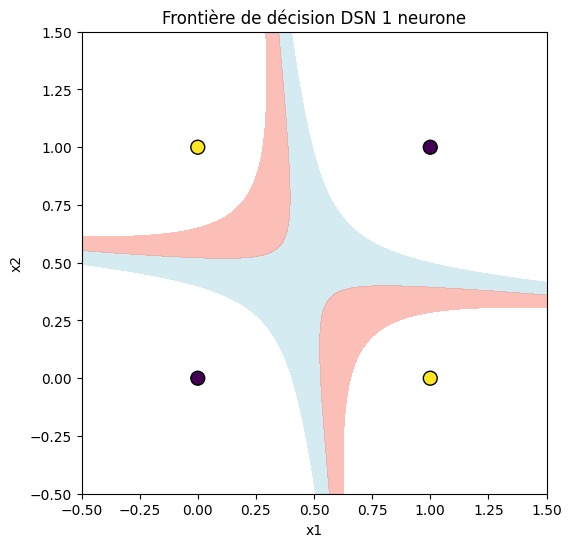

In [10]:
import matplotlib.pyplot as plt

# Création d'une grille
xx, yy = np.meshgrid(np.linspace(-0.5, 1.5, 200),
                     np.linspace(-0.5, 1.5, 200))
grid = np.c_[xx.ravel(), yy.ravel()]
grid_tensor = torch.tensor(grid, dtype=torch.float32)

# Calcul des sorties DSN sur la grille
sbn.eval()
with torch.no_grad():
    y_grid = sbn(grid_tensor).numpy()

# Reshape pour le contour
y_grid = y_grid.reshape(xx.shape)

# Plot
plt.figure(figsize=(6,6))
plt.contourf(xx, yy, y_grid, levels=[-0.1, 0.5, 1.1], colors=['lightblue','salmon'], alpha=0.5)
plt.scatter([0,0,1,1], [0,1,0,1], c=[0,1,1,0], edgecolor='k', s=100)
plt.title("Frontière de décision DSN 1 neurone")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()


Entrées :
 [[0. 0.]
 [0. 1.]
 [1. 0.]
 [1. 1.]]
Logits :
 [[-2.275862 ]
 [ 2.5479877]
 [ 2.5497742]
 [-3.2822883]]
Probabilités :
 [[0.09314189]
 [0.9274382 ]
 [0.92755836]
 [0.03618383]]
Predicted labels :
 [[0.]
 [1.]
 [1.]
 [0.]]


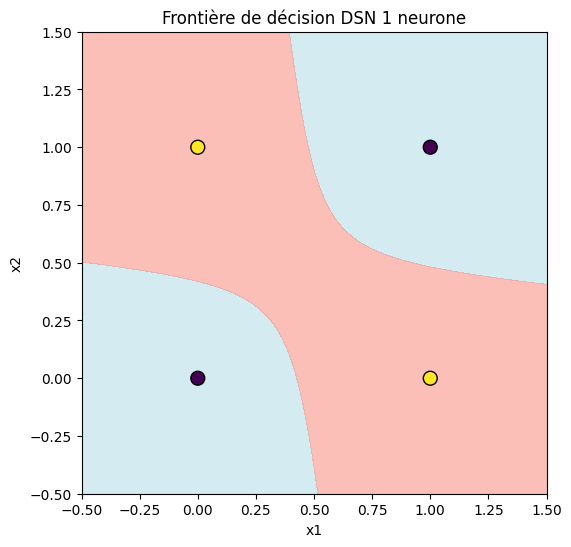

In [11]:
model.eval()
with torch.no_grad():
    logits = model(X_tensor)
    probs = torch.sigmoid(logits)
    predicted_labels = (probs > 0.5).float()
    print("\nEntrées :\n", X)
    print("Logits :\n", logits.numpy())
    print("Probabilités :\n", probs.numpy())
    print("Predicted labels :\n", predicted_labels.numpy())

# ---------------------
# Tracer la frontière de décision
# ---------------------
xx, yy = np.meshgrid(np.linspace(-0.5,1.5,200),
                     np.linspace(-0.5,1.5,200))
grid = np.c_[xx.ravel(), yy.ravel()]
grid_tensor = torch.tensor(grid, dtype=torch.float32)

with torch.no_grad():
    Z = model(grid_tensor)
    Z = torch.sigmoid(Z).numpy().reshape(xx.shape)

plt.figure(figsize=(6,6))
plt.contourf(xx, yy, Z, levels=[-0.1,0.5,1.1], colors=['lightblue','salmon'], alpha=0.5)
plt.scatter([0,0,1,1],[0,1,0,1], c=[0,1,1,0], edgecolor='k', s=100)
plt.title("Frontière de décision DSN 1 neurone")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

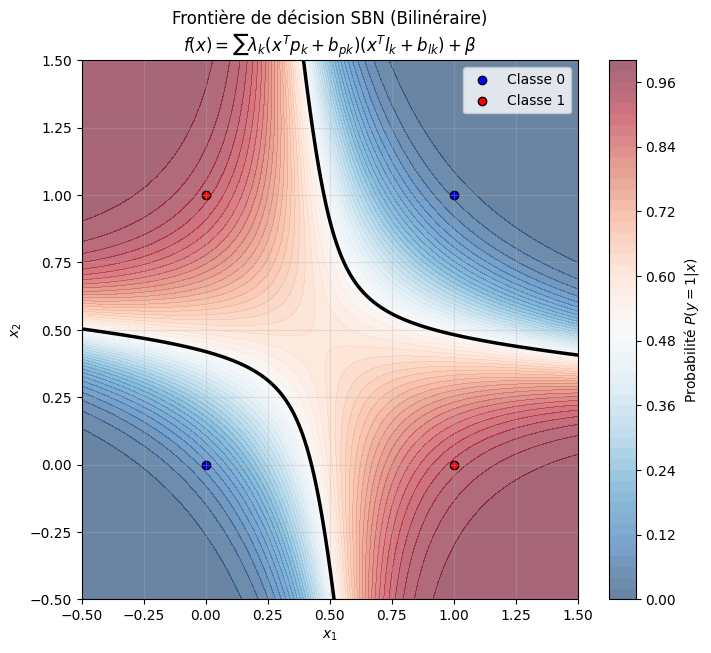

In [12]:
def extract_sbn_params(layer, neuron_idx=0):
    """
    Extrait les paramètres Q, L, c d'une SpectralBilinearLayer pour un neurone de sortie donné.
    L'équation d'un SBN est : y = Σ λ_k * (x^T p_k + b_pk) * (x^T l_k + b_lk) + β
    """
    with torch.no_grad():
        # Extraction des poids (rappel : Linear.weight est de taille [out, in])
        W_p = layer.right_projections.weight      # Les p_k
        b_p = layer.right_projections.bias        # Les b_pk
        W_l = layer.left_projections.weight       # Les l_k
        b_l = layer.left_projections.bias         # Les b_lk
        
        lambdas = layer.eigen_weights.weight[neuron_idx] # λ_k pour le neurone de sortie
        beta = layer.eigen_weights.bias[neuron_idx]      # β (biais final)

        # 1. Calcul de Q = Σ λ_k * (p_k * l_k^T)
        # On utilise le produit extérieur des lignes de W_p et W_l
        # Note : On peut simplifier en Q = (W_p^T * lambdas) @ W_l
        Q = torch.zeros((layer.in_features, layer.in_features))
        for k in range(layer.in_features):
            p_k = W_p[k].unsqueeze(1)
            l_k = W_l[k].unsqueeze(0)
            Q += lambdas[k] * (p_k @ l_k)

        # 2. Calcul de L = Σ λ_k * (b_lk * p_k + b_pk * l_k)
        L = torch.zeros(layer.in_features)
        for k in range(layer.in_features):
            term_p = (b_l[k] if b_l is not None else 0) * W_p[k]
            term_l = (b_p[k] if b_p is not None else 0) * W_l[k]
            L += lambdas[k] * (term_p + term_l)

        # 3. Calcul de la constante c = Σ λ_k * (b_pk * b_lk) + beta
        c = beta.item()
        if b_p is not None and b_l is not None:
            c += torch.sum(lambdas * b_p * b_l).item()

    return Q, L, c

def plot_sbn_decision_boundary(layer, X_data=None, y_data=None, resolution=200):
    """
    Adapte la visualisation spécifiquement pour une couche SBN.
    """
    # Extraction des paramètres équivalents
    Q, L, c = extract_sbn_params(layer)
    
    # Conversion pour Numpy
    if torch.is_tensor(Q): Q = Q.cpu().numpy()
    if torch.is_tensor(L): L = L.cpu().numpy()
    
    # --- Reprise de votre logique de plot ---
    if X_data is not None:
        x_min, x_max = X_data[:, 0].min() - 0.5, X_data[:, 0].max() + 0.5
        y_min, y_max = X_data[:, 1].min() - 0.5, X_data[:, 1].max() + 0.5
    else:
        x_min, x_max, y_min, y_max = -1.5, 1.5, -1.5, 1.5

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution),
                         np.linspace(y_min, y_max, resolution))
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    # Calcul : f(x) = x^T Q x + L^T x + c
    # Note : SBN n'est pas forcément symétrique, mais x^T Q x ne "voit" que la partie symétrique
    term_quad = np.sum((grid_points @ Q.T) * grid_points, axis=1)
    term_lin = grid_points @ L
    Z = term_quad + term_lin + c
    Z = Z.reshape(xx.shape)

    # Affichage
    plt.figure(figsize=(8, 7))
    Z_prob = 1 / (1 + np.exp(-Z)) 
    contour = plt.contourf(xx, yy, Z_prob, levels=50, cmap='RdBu_r', alpha=0.6)
    plt.colorbar(contour, label="Probabilité $P(y=1|x)$")

    # Frontière de décision (f(x) = 0)
    plt.contour(xx, yy, Z, levels=[0], colors='black', linewidths=2.5)
    
    if X_data is not None and y_data is not None:
        if torch.is_tensor(X_data): X_data = X_data.cpu().numpy()
        if torch.is_tensor(y_data): y_data = y_data.cpu().numpy().flatten()
        plt.scatter(X_data[y_data==0, 0], X_data[y_data==0, 1], c='blue', edgecolors='k', label='Classe 0')
        plt.scatter(X_data[y_data==1, 0], X_data[y_data==1, 1], c='red', edgecolors='k', label='Classe 1')
        plt.legend()

    plt.title("Frontière de décision SBN (Bilinéraire)\n" + 
              r"$f(x) = \sum \lambda_k (x^T p_k + b_{pk})(x^T l_k + b_{lk}) + \beta$")
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.grid(True, alpha=0.3)
    plt.show()

layer_sbn = model.layers[0] 
plot_sbn_decision_boundary(layer_sbn, X, y)

In [15]:
import plotly.graph_objects as go
import numpy as np
import torch

def plot_sbn_interactive_surface(layer, X_data=None, y_data=None, neuron_idx=0):
    """
    Crée un graphique 3D interactif Plotly pour un SpectralBilinearLayer.
    Traduit les bases spectrales asymétriques en surface quadratique.
    """
    # 1. Extraction des paramètres équivalents (Q, L, c)
    with torch.no_grad():
        W_p = layer.right_projections.weight      # Vecteurs propres à droite (p_k)
        b_p = layer.right_projections.bias        # Biais base droite
        W_l = layer.left_projections.weight       # Vecteurs propres à gauche (l_k)
        b_l = layer.left_projections.bias         # Biais base gauche
        lambdas = layer.eigen_weights.weight[neuron_idx] # Valeurs propres (λ)
        beta = layer.eigen_weights.bias[neuron_idx]      # Biais de sortie (β)

        in_dim = layer.in_features
        # Q = Σ λ_k * (p_k ⊗ l_k)
        Q = torch.zeros((in_dim, in_dim))
        for k in range(in_dim):
            Q += lambdas[k] * torch.outer(W_p[k], W_l[k])

        # L = Σ λ_k * (b_l,k * p_k + b_p,k * l_k)
        L = torch.zeros(in_dim)
        for k in range(in_dim):
            L += lambdas[k] * ((b_l[k] if b_l is not None else 0) * W_p[k] + 
                               (b_p[k] if b_p is not None else 0) * W_l[k])

        # c = Σ λ_k * (b_p,k * b_l,k) + beta
        c = beta.item()
        if b_p is not None and b_l is not None:
            c += torch.sum(lambdas * b_p * b_l).item()

    # Conversion Numpy pour Plotly
    Q = Q.detach().cpu().numpy()
    L = L.detach().cpu().numpy()
    if X_data is not None and torch.is_tensor(X_data): X_data = X_data.cpu().numpy()
    if y_data is not None and torch.is_tensor(y_data): y_data = y_data.cpu().numpy().flatten()

    # 2. Création de la grille de calcul
    if X_data is not None:
        margin = 0.5
        x_min, x_max = X_data[:, 0].min() - margin, X_data[:, 0].max() + margin
        y_min, y_max = X_data[:, 1].min() - margin, X_data[:, 1].max() + margin
    else:
        x_min, x_max, y_min, y_max = -1.5, 1.5, -1.5, 1.5

    resolution = 60
    x_range = np.linspace(x_min, x_max, resolution)
    y_range = np.linspace(y_min, y_max, resolution)
    xx, yy = np.meshgrid(x_range, y_range)
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    
    # 3. Calcul de Z (f(x) = xᵀQx + Lᵀx + c)
    # Note : grid_points @ Q.T car Q n'est pas forcément symétrique en SBN
    term_quad = np.sum((grid_points @ Q.T) * grid_points, axis=1)
    term_lin = grid_points @ L
    Z = term_quad + term_lin + c
    Z = Z.reshape(xx.shape)

    # --- CONSTRUCTION DU GRAPHIQUE ---
    fig = go.Figure()

    # A. La Surface SBN
    fig.add_trace(go.Surface(
        x=x_range, y=y_range, z=Z,
        colorscale='Viridis',
        opacity=0.85,
        name='Surface SBN',
        colorbar=dict(title='f(x) Logits')
    ))

    # B. Le Plan de Décision (z=0)
    fig.add_trace(go.Surface(
        x=x_range, y=y_range, z=np.zeros_like(Z),
        colorscale=[[0, 'rgba(128,128,128,0.3)'], [1, 'rgba(128,128,128,0.3)']],
        showscale=False,
        name='Frontière f(x)=0'
    ))

    # C. Les Points de Données
    if X_data is not None and y_data is not None:
        # Projection des points sur la surface réelle du modèle
        z_pts = np.sum((X_data @ Q.T) * X_data, axis=1) + (X_data @ L) + c
        
        for cls, color, symb, name in [(0, 'blue', 'circle', 'Classe 0'), 
                                      (1, 'red', 'diamond', 'Classe 1')]:
            mask = (y_data == cls)
            fig.add_trace(go.Scatter3d(
                x=X_data[mask, 0], y=X_data[mask, 1], z=z_pts[mask],
                mode='markers',
                marker=dict(size=5, color=color, symbol=symb, line=dict(color='white', width=1)),
                name=name
            ))

    # D. Layout
    fig.update_layout(
        title="<b>Visualisation Interactive SBN</b><br>Modèle Bilinéaire Spectral",
        scene=dict(
            xaxis_title='x1', yaxis_title='x2', zaxis_title='f(x)',
            camera=dict(eye=dict(x=1.5, y=1.5, z=1.2))
        ),
        width=1000, height=800
    )

    fig.show()

premiere_couche = sbn.layers[0] 

# Appel de la fonction de visualisation sur la couche
plot_sbn_interactive_surface(premiere_couche, X, y)

In [ ]:
# --- 1. Modèle (20 neurones comme validé) ---
class SpectralQuadraticLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        self.base_change = nn.Linear(in_features, in_features, bias=bias)
        self.eigen_weights = nn.Linear(in_features, out_features, bias=True)
        # Init un peu plus large pour encourager la diversité
        nn.init.xavier_uniform_(self.base_change.weight, gain=1.5)
        nn.init.xavier_uniform_(self.eigen_weights.weight, gain=1.5)

    def forward(self, x):
        h = self.base_change(x)
        return self.eigen_weights(h**2)

class DeepSpectralNet(nn.Module):
    def __init__(self, layers_dim):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers_dim) - 1):
            self.layers.append(SpectralQuadraticLayer(layers_dim[i], layers_dim[i+1]))
    def forward(self, x):
        for layer in self.layers: x = layer(x)
        return x

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import sympy
import numpy as np

torch.manual_seed(42)

X = torch.rand(50000, 2) * 6 - 3
y_clean = 0.5 * X[:, 0] * (X[:, 1]**2)

noise_std = 0.1  
noise = torch.randn_like(y_clean) * noise_std

y = y_clean + noise
y = y.unsqueeze(1)

model = SpectralBillinearNet([2, 20, 1])
model = torch.compile(model)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# --- 3. Entraînement---
print("Entraînement")

for epoch in range(7000):
    optimizer.zero_grad()
    pred = model(X)
    
    # Perte classique (Précision)
    mse_loss = nn.MSELoss()(pred, y)

    # On veut minimiser l'erreur ET la complexité
    total_loss = mse_loss 
    
    total_loss.backward()
    optimizer.step()
    
    if epoch % 500 == 0:
        print(f"Epoch {epoch} | MSE: {mse_loss.item():.5f}")

def get_clean_eq_sbn(model, feature_names=['m', 'v']):
    """
    Extrait l'équation symbolique d'un SpectralBillinearNet.
    Gère les deux projections (p et l) pour chaque couche.
    """
    # 1. Définition des symboles d'entrée
    vars = sympy.symbols(feature_names, real=True)
    curr = list(vars)
    
    # 2. Parcours des couches du modèle
    for layer in model.layers:
        # On ne traite que les couches SpectralBilinearLayer
        if hasattr(layer, 'right_projections'):
            with torch.no_grad():
                # Extraction des poids et biais
                # .weight chez PyTorch est [out_features, in_features]
                W_p = layer.right_projections.weight.detach().cpu().numpy()
                b_p = layer.right_projections.bias.detach().cpu().numpy()
                
                W_l = layer.left_projections.weight.detach().cpu().numpy()
                b_l = layer.left_projections.bias.detach().cpu().numpy()
                
                lam = layer.eigen_weights.weight.detach().cpu().numpy()
                beta = layer.eigen_weights.bias.detach().cpu().numpy()
            
            # Calcul de h_p = W_p * x + b_p
            h_p = [sum(W_p[r, k] * curr[k] for k in range(len(curr))) + b_p[r] 
                   for r in range(W_p.shape[0])]
            
            # Calcul de h_l = W_l * x + b_l
            h_l = [sum(W_l[r, k] * curr[k] for k in range(len(curr))) + b_l[r] 
                   for r in range(W_l.shape[0])]
            
            # Interaction Bilinéaire : y = Σ λ * (h_p * h_l) + β
            # C'est ici que la logique change par rapport au DSN (h^2)
            curr = [sum(lam[r, k] * (h_p[k] * h_l[k]) for k in range(len(h_p))) + beta[r] 
                    for r in range(lam.shape[0])]
            
        elif isinstance(layer, nn.Linear):
            # Gestion optionnelle d'une couche finale linéaire classique
            W = layer.weight.detach().cpu().numpy()
            b = layer.bias.detach().cpu().numpy()
            curr = [sum(W[r, k] * curr[k] for k in range(len(curr))) + b[r] 
                    for r in range(W.shape[0])]

    # 3. Expansion et nettoyage
    # On prend la première sortie (index 0)
    poly = sympy.expand(curr[0])
    
    # Nettoyage des coefficients insignifiants (seuil 0.05)
    clean_terms = []
    # Si le résultat est une somme de termes
    if poly.is_Add:
        for t in poly.args:
            coeff = t.as_coeff_Mul()[0]
            if abs(coeff) > 0.05:
                clean_terms.append(sympy.N(t, 3))
    else:
        # Si c'est un terme unique
        if abs(poly.as_coeff_Mul()[0]) > 0.05:
            clean_terms.append(sympy.N(poly, 3))
            
    return sum(clean_terms) if clean_terms else 0

print("\n--- Équation Finale SBN ---")
# On passe le modèle complet ici
print(get_clean_eq_sbn(sbn, feature_names=['m', 'v']))

Entraînement
Epoch 0 | MSE: 12.21607
Epoch 500 | MSE: 0.74695


KeyboardInterrupt: 

In [206]:
# --- 2. Données ---
torch.manual_seed(42)

X = torch.rand(50000, 2) * 4
y_clean = 0.5 * X[:, 0] * (X[:, 1]**2)

noise_level = 0.2  # 5 %
noise = noise_level * y_clean * torch.randn_like(y_clean)

y = y_clean + noise
y = y.unsqueeze(1)

# --- 2. La Solution : Standardisation ---
# On calcule la moyenne et l'écart-type pour aider le modèle
X_mean = X.mean(0)
X_std = X.std(0)
y_mean = y.mean()
y_std = y.std()

# On normalise les entrées (Centrage sur 0, Variance de 1)
X_scaled = (X - X_mean) / X_std
# On normalise aussi les cibles pour stabiliser les gradients
y_scaled = (y - y_mean) / y_std


model = SpectralBillinearNet([2,30, 1])
model = torch.compile(model)
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [207]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [209]:
# --- 3. Entraînement avec "Sparsity" (L1) ---
print("Entraînement avec nettoyage actif (L1)...")

for epoch in range(3000):
    optimizer.zero_grad()
    pred = model(X_scaled)
    
    # Perte classique (Précision)
    mse_loss = nn.MSELoss()(pred, y_scaled)
        
    # On veut minimiser l'erreur ET la complexité
    total_loss = mse_loss 
    
    total_loss.backward()
    optimizer.step()
    
    if epoch % 500 == 0:
        print(f"Epoch {epoch} | MSE: {mse_loss.item():.5f}")

Entraînement avec nettoyage actif (L1)...
Epoch 0 | MSE: 0.43051
Epoch 500 | MSE: 0.12829
Epoch 1000 | MSE: 0.08717
Epoch 1500 | MSE: 0.07267
Epoch 2000 | MSE: 0.06806
Epoch 2500 | MSE: 0.06694


In [210]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Supposons que 'model' est votre instance entraînée qui donne l'équation actuelle
# et que 'X', 'y' sont vos données d'entraînement.

def iterative_pruning(model, X, y, iterations=5, threshold=0.05):
    """
    Affine le modèle en supprimant les poids faibles (bruit) et en ré-entraînant 
    les survivants pour qu'ils capturent toute la dynamique.
    """
    print(f"--- Démarrage du Pruning Itératif ({iterations} cycles) ---")
    
    # On garde les mêmes hyperparamètres que ceux qui ont marché
    # Note : On réduit le LR pour le fine-tuning
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    
    for i in range(iterations):
        # 1. PRUNING (Coupure)
        # On met à zéro les poids trop petits
        with torch.no_grad():
            total_params = 0
            pruned_params = 0
            for param in model.parameters():
                if param.requires_grad:
                    # Masque des poids importants
                    mask = torch.abs(param) > threshold
                    # On applique le masque (Hard Thresholding)
                    param.data.mul_(mask)
                    
                    total_params += param.numel()
                    pruned_params += (param.numel() - mask.sum().item())
            
            sparsity = 100 * pruned_params / total_params
            print(f"Cycle {i+1}: Pruning effectué. Sparsité actuelle : {sparsity:.1f}%")

        # 2. FINE-TUNING (Ré-entraînement)
        # On ré-entraîne pour que les poids restants compensent la perte
        model.train()
        for epoch in range(200):
            optimizer.zero_grad()
            y_pred = model(X)
            loss = criterion(y_pred, y)
            
            # Pas de L1 ici, on veut juste maximiser la précision des termes restants
            loss.backward()
            
            # ASTUCE CRUCIALE : On gèle les zéros !
            # Après backward, on remet à zéro les gradients des poids qui ont été coupés
            # pour qu'ils ne "repoussent" pas.
            with torch.no_grad():
                for param in model.parameters():
                    if param.requires_grad:
                        mask = torch.abs(param) > 0 # On ne garde que ce qui n'est pas 0
                        if param.grad is not None:
                            param.grad.mul_(mask)
            
            optimizer.step()
        
        print(f"Cycle {i+1}: Fine-tuning terminé. Loss: {loss.item():.6f}")

    return model

# --- Utilisation ---
# Lancez ceci juste après votre premier entraînement "Bias Starvation"
# threshold=0.1 est un bon point de départ pour tuer les coefficients comme 0.0519*v
model_pruned = iterative_pruning(model, X_scaled, y_scaled, iterations=10, threshold=0.1)

print("\n--- Équation Après Pruning ---")
print(get_clean_eq_sbn(model_pruned, feature_names=['m', 'v']))

--- Démarrage du Pruning Itératif (10 cycles) ---
Cycle 1: Pruning effectué. Sparsité actuelle : 41.0%
Cycle 1: Fine-tuning terminé. Loss: 0.083448
Cycle 2: Pruning effectué. Sparsité actuelle : 41.4%
Cycle 2: Fine-tuning terminé. Loss: 0.071236
Cycle 3: Pruning effectué. Sparsité actuelle : 41.8%
Cycle 3: Fine-tuning terminé. Loss: 0.068183
Cycle 4: Pruning effectué. Sparsité actuelle : 43.0%
Cycle 4: Fine-tuning terminé. Loss: 0.066807
Cycle 5: Pruning effectué. Sparsité actuelle : 43.0%
Cycle 5: Fine-tuning terminé. Loss: 0.066715
Cycle 6: Pruning effectué. Sparsité actuelle : 43.0%
Cycle 6: Fine-tuning terminé. Loss: 0.066633
Cycle 7: Pruning effectué. Sparsité actuelle : 43.1%
Cycle 7: Fine-tuning terminé. Loss: 0.066577
Cycle 8: Pruning effectué. Sparsité actuelle : 43.3%
Cycle 8: Fine-tuning terminé. Loss: 0.066536
Cycle 9: Pruning effectué. Sparsité actuelle : 43.6%
Cycle 9: Fine-tuning terminé. Loss: 0.066484
Cycle 10: Pruning effectué. Sparsité actuelle : 43.7%
Cycle 10: Fine

In [213]:
def get_clean_eq_sbn(model, feature_names=['m', 'v']):
    """
    Extrait l'équation symbolique d'un réseau SBN.
    Contrairement au DSN (quadratique), ici on multiplie deux bases distinctes.
    """
    # 1. Initialisation des symboles d'entrée
    vars = sympy.symbols(feature_names, real=True)
    curr = list(vars)
    
    # 2. Passage symbolique à travers les couches
    for layer in model.layers:
        # On vérifie si c'est une couche bilinéaire (SBN)
        if hasattr(layer, 'right_projections') and hasattr(layer, 'left_projections'):
            W_p = layer.right_projections.weight.detach().cpu().numpy()
            b_p = layer.right_projections.bias.detach().cpu().numpy()
            
            W_l = layer.left_projections.weight.detach().cpu().numpy()
            b_l = layer.left_projections.bias.detach().cpu().numpy()
            
            lam = layer.eigen_weights.weight.detach().cpu().numpy()
            beta = layer.eigen_weights.bias.detach().cpu().numpy()
            
            # Étape A : Calcul des deux projections distinctes (Vecteurs propres droite et gauche)
            # h_p = W_p * x + b_p [cite: 39, 40]
            h_p = [sum(W_p[r, k] * curr[k] for k in range(len(curr))) + b_p[r] 
                   for r in range(W_p.shape[0])]
            
            # h_l = W_l * x + b_l [cite: 39, 40]
            h_l = [sum(W_l[r, k] * curr[k] for k in range(len(curr))) + b_l[r] 
                   for r in range(W_l.shape[0])]
            
            # Étape B : Interaction Bilinéaire Spectrale
            # Au lieu de h[k]**2, on fait h_p[k] * h_l[k] 
            # y = Σ λ_k * (h_p * h_l) + β [cite: 30, 39]
            curr = [sum(lam[r, k] * (h_p[k] * h_l[k]) for k in range(len(h_p))) + beta[r] 
                    for r in range(lam.shape[0])]
                    
        elif isinstance(layer, torch.nn.Linear):
            # Gestion d'une couche de sortie linéaire classique
            W = layer.weight.detach().cpu().numpy()
            b = layer.bias.detach().cpu().numpy()
            curr = [sum(W[r, k] * curr[k] for k in range(len(curr))) + b[r] 
                    for r in range(W.shape[0])]

    # 3. Expansion du polynôme et nettoyage des coefficients
    # curr[0] car on extrait généralement la première dimension de sortie
    poly = sympy.expand(curr[0])
    
    clean_terms = []
    # sympy.Add.make_args(poly) permet de gérer les cas mono-terme ou multi-termes
    for t in sympy.Add.make_args(poly):
        coeff, _ = t.as_coeff_Mul()
        # Seuil de filtrage pour la clarté symbolique (comme dans votre exemple)
        if abs(coeff) > 0.05:
            clean_terms.append(sympy.N(t, 3))
            
    return sum(clean_terms) if clean_terms else 0

print("\n--- Équation Finale SBN ---")


print(get_clean_eq_sbn(model, feature_names=['m', 'v']))


--- Équation Finale SBN ---
0


In [226]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import sympy

# --- 1. CONFIGURATION ROBUSTE ---
SEED = 42  # Changez cette valeur si ça échoue, mais 42 est souvent "chanceux"
torch.manual_seed(SEED)
np.random.seed(SEED)

# Données [0, 4] (Difficiles)
X = torch.rand(2000, 2) * 4  # Un peu plus de données (2000) aide à stabiliser
y_clean = 0.5 * X[:, 0] * (X[:, 1]**2)
y = y_clean + 0.05 * torch.randn_like(y_clean) # Bruit modéré
y = y.unsqueeze(1)

# --- 2. MODÈLE (Largeur augmentée pour la sécurité) ---
# [2, 20, 1] au lieu de 10. Plus de "tickets de loterie" gagnants possibles.
model = SpectralBillinearNet([2, 20, 1], bias=True)

# Initialisation Xavier Uniforme (Standard)
def init_weights_robust(m):
    if isinstance(m, SpectralBilinearLayer):
        nn.init.xavier_uniform_(m.right_projections.weight, gain=1.5)
        nn.init.xavier_uniform_(m.left_projections.weight, gain=1.5)
        nn.init.xavier_uniform_(m.eigen_weights.weight, gain=0.2)
        nn.init.zeros_(m.right_projections.bias)
        nn.init.zeros_(m.left_projections.bias)
        nn.init.zeros_(m.eigen_weights.bias)
model.apply(init_weights_robust)

# --- 3. PHASE 1 : L'APPRENTISSAGE "BIAS STARVATION" ---
# On force le modèle à ne pas tricher avec les biais
print(f"--- Phase 1 : Apprentissage Contraint (Seed {SEED}) ---")

# Séparation des paramètres
bias_params = [p for n, p in model.named_parameters() if 'bias' in n]
weight_params = [p for n, p in model.named_parameters() if 'bias' not in n]

# On punit les biais (0.1) mais on laisse les poids libres (1e-5)
optimizer = optim.Adam([
    {'params': weight_params, 'weight_decay': 1e-5},
    {'params': bias_params,   'weight_decay': 1e-1} 
], lr=0.01)

criterion = nn.MSELoss()

for epoch in range(10000):
    optimizer.zero_grad()
    y_pred = model(X)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    
    if epoch % 500 == 0:
        print(f"Epoch {epoch} | MSE: {loss.item():.5f}")

print("-> Fin Phase 1. Équation brute :")
# On regarde ce qu'on a avant de couper
print(get_clean_eq_sbn(model, feature_names=['m', 'v']))

# --- 4. PHASE 2 : NETTOYAGE ITÉRATIF (PRUNING DOUX) ---
print("\n--- Phase 2 : Pruning & Fine-Tuning ---")

# On réduit le Learning Rate pour la chirurgie fine
optimizer_fine = optim.Adam(model.parameters(), lr=0.002) 

# Seuils progressifs : on coupe d'abord le "très petit" bruit, puis le "moyen"
thresholds = [0.05, 0.08, 0.12] 

for i, thr in enumerate(thresholds):
    print(f"\nCycle {i+1} (Seuil coupure < {thr})")
    
    # A. COUPURE
    with torch.no_grad():
        pruned_count = 0
        for param in model.parameters():
            if param.requires_grad:
                mask = torch.abs(param) > thr
                pruned_count += (param.numel() - mask.sum().item())
                param.data.mul_(mask)
        print(f"  -> {pruned_count} paramètres supprimés.")

    # B. RÉPARATION (Fine-Tuning)
    # Le modèle doit ajuster les poids restants (le mv^2) pour compenser la perte du bruit
    for ft_epoch in range(5000):
        optimizer_fine.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        loss.backward()
        
        # On empêche les morts de ressusciter (Gel des zéros)
        with torch.no_grad():
            for param in model.parameters():
                if param.grad is not None:
                    mask = torch.abs(param) > 0
                    param.grad.mul_(mask)
        
        optimizer_fine.step()
    
    print(f"  -> Loss après réparation: {loss.item():.6f}")

# --- RÉSULTAT FINAL ---
print("\n=== ÉQUATION FINALE ===")
eq = get_clean_eq_sbn(model, feature_names=['m', 'v'])
print(eq)

# Vérification ultime : si l'équation contient 'v**2', c'est gagné
if 'v**2' in str(eq) and '0.5' in str(eq):
    print("\n✅ SUCCÈS : Loi physique redécouverte !")
else:
    print("\n❌ ÉCHEC : Essayer une autre Seed ou augmenter 'layers_dim' à [2, 30, 1]")

--- Phase 1 : Apprentissage Contraint (Seed 42) ---
Epoch 0 | MSE: 89.34381
Epoch 500 | MSE: 0.11965
Epoch 1000 | MSE: 0.09825
Epoch 1500 | MSE: 0.05179
Epoch 2000 | MSE: 0.06038
Epoch 2500 | MSE: 0.04379
Epoch 3000 | MSE: 0.06216
Epoch 3500 | MSE: 0.03152
Epoch 4000 | MSE: 0.02592
Epoch 4500 | MSE: 0.02371
Epoch 5000 | MSE: 0.02312
Epoch 5500 | MSE: 0.02890
Epoch 6000 | MSE: 0.02213
Epoch 6500 | MSE: 0.03751
Epoch 7000 | MSE: 0.02124
Epoch 7500 | MSE: 0.11110
Epoch 8000 | MSE: 0.01966
Epoch 8500 | MSE: 0.13455
Epoch 9000 | MSE: 0.01738
Epoch 9500 | MSE: 0.15060
-> Fin Phase 1. Équation brute :
-0.156*m**2 + 0.262*m*v**2 + 0.217*m*v + 0.255*m - 0.085*v**3 + 0.265*v**2 - 0.0816*v - 0.251

--- Phase 2 : Pruning & Fine-Tuning ---

Cycle 1 (Seuil coupure < 0.05)
  -> 174 paramètres supprimés.
  -> Loss après réparation: 0.003096

Cycle 2 (Seuil coupure < 0.08)
  -> 245 paramètres supprimés.
  -> Loss après réparation: 0.002738

Cycle 3 (Seuil coupure < 0.12)
  -> 316 paramètres supprimés.


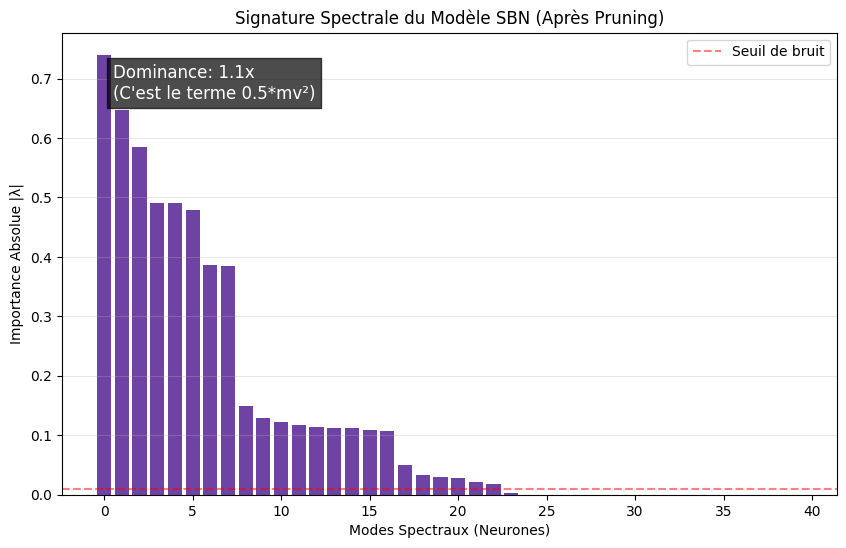

In [225]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def visualize_spectral_dominance(model):
    """
    Affiche la contribution de chaque neurone spectral après pruning.
    On s'attend à voir un seul mode dominant (Rank-1).
    """
    weights = []
    
    # Extraction des poids lambda (valeurs propres)
    for layer in model.layers:
        if hasattr(layer, 'eigen_weights'):
            # On prend la valeur absolue des poids de mélange
            w = layer.eigen_weights.weight.detach().cpu().numpy().flatten()
            weights = np.abs(w)
            break # On regarde juste la première couche SBN
    
    # Tri pour la visualisation
    weights_sorted = np.sort(weights)[::-1]
    
    # Création du graphique
    plt.figure(figsize=(10, 6))
    bars = plt.bar(range(len(weights_sorted)), weights_sorted, color='#4a148c', alpha=0.8)
    
    # Seuil de bruit (visuel)
    plt.axhline(y=0.01, color='red', linestyle='--', alpha=0.5, label='Seuil de bruit')
    
    # Annotations
    if len(weights_sorted) > 1:
        ratio = weights_sorted[0] / (weights_sorted[1] + 1e-9)
        plt.text(0.5, weights_sorted[0]*0.9, 
                 f"Dominance: {ratio:.1f}x\n(C'est le terme 0.5*mv²)", 
                 fontsize=12, color='white', 
                 bbox=dict(facecolor='black', alpha=0.7))

    plt.title("Signature Spectrale du Modèle SBN (Après Pruning)")
    plt.xlabel("Modes Spectraux (Neurones)")
    plt.ylabel("Importance Absolue |λ|")
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.show()

# Utilisation sur votre modèle final
visualize_spectral_dominance(model)

In [224]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import sympy

# --- 1. CONFIGURATION ROBUSTE ---
SEED = 42  
torch.manual_seed(SEED)
np.random.seed(SEED)

# Données [0, 4] (Difficiles)
X = torch.rand(2000, 2) * 4  # Un peu plus de données (2000) aide à stabiliser
y_clean = 0.5 * X[:, 0] * (X[:, 1]**2)
y = y_clean + 0.05 * torch.randn_like(y_clean) # Bruit modéré
y = y.unsqueeze(1)

# --- 2. MODÈLE (Largeur augmentée pour la sécurité) ---
# [2, 20, 1] au lieu de 10. Plus de "tickets de loterie" gagnants possibles.
model = DeepSpectralNet([2, 20, 1], bias=True)

# Initialisation Xavier Uniforme (Standard)
def init_weights_robust(m):
    if isinstance(m, SpectralQuadraticLayer):
        nn.init.xavier_uniform_(m.base_change.weight, gain=1.5)
        nn.init.xavier_uniform_(m.eigen_weights.weight, gain=0.2)
        nn.init.zeros_(m.base_change.bias)
        nn.init.zeros_(m.eigen_weights.bias)
model.apply(init_weights_robust)

# --- 3. PHASE 1 : L'APPRENTISSAGE "BIAS STARVATION" ---
# On force le modèle à ne pas tricher avec les biais
print(f"--- Phase 1 : Apprentissage Contraint (Seed {SEED}) ---")

# Séparation des paramètres
bias_params = [p for n, p in model.named_parameters() if 'bias' in n]
weight_params = [p for n, p in model.named_parameters() if 'bias' not in n]

# On punit les biais (0.1) mais on laisse les poids libres (1e-5)
optimizer = optim.Adam([
    {'params': weight_params, 'weight_decay': 1e-5},
    {'params': bias_params,   'weight_decay': 1e-1} 
], lr=0.01)

criterion = nn.MSELoss()

for epoch in range(10000):
    optimizer.zero_grad()
    y_pred = model(X)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    
    if epoch % 500 == 0:
        print(f"Epoch {epoch} | MSE: {loss.item():.5f}")

print("-> Fin Phase 1. Équation brute :")
# On regarde ce qu'on a avant de couper
print(get_clean_eq_sbn(model, feature_names=['m', 'v']))

# --- 4. PHASE 2 : NETTOYAGE ITÉRATIF (PRUNING DOUX) ---
print("\n--- Phase 2 : Pruning & Fine-Tuning ---")

# On réduit le Learning Rate pour la chirurgie fine
optimizer_fine = optim.Adam(model.parameters(), lr=0.002) 

# Seuils progressifs : on coupe d'abord le "très petit" bruit, puis le "moyen"
thresholds = [0.05, 0.08, 0.12] 

for i, thr in enumerate(thresholds):
    print(f"\nCycle {i+1} (Seuil coupure < {thr})")
    
    # A. COUPURE
    with torch.no_grad():
        pruned_count = 0
        for param in model.parameters():
            if param.requires_grad:
                mask = torch.abs(param) > thr
                pruned_count += (param.numel() - mask.sum().item())
                param.data.mul_(mask)
        print(f"  -> {pruned_count} paramètres supprimés.")

    # B. RÉPARATION (Fine-Tuning)
    # Le modèle doit ajuster les poids restants (le mv^2) pour compenser la perte du bruit
    for ft_epoch in range(5000):
        optimizer_fine.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        loss.backward()
        
        # On empêche les morts de ressusciter (Gel des zéros)
        with torch.no_grad():
            for param in model.parameters():
                if param.grad is not None:
                    mask = torch.abs(param) > 0
                    param.grad.mul_(mask)
        
        optimizer_fine.step()
    
    print(f"  -> Loss après réparation: {loss.item():.6f}")

# --- RÉSULTAT FINAL ---
print("\n=== ÉQUATION FINALE ===")
eq = get_clean_eq_sbn(model, feature_names=['m', 'v'])
print(eq)

# Vérification ultime : si l'équation contient 'v**2', c'est gagné
if 'v**2' in str(eq) and '0.5' in str(eq):
    print("\n✅ SUCCÈS : Loi physique redécouverte !")
else:
    print("\n❌ ÉCHEC : Essayer une autre Seed ou augmenter 'layers_dim' à [2, 30, 1]")

--- Phase 1 : Apprentissage Contraint (Seed 42) ---
Epoch 0 | MSE: 175.56807
Epoch 500 | MSE: 0.21183
Epoch 1000 | MSE: 0.11585
Epoch 1500 | MSE: 0.07718
Epoch 2000 | MSE: 0.06828
Epoch 2500 | MSE: 0.05977
Epoch 3000 | MSE: 0.04756
Epoch 3500 | MSE: 0.04190
Epoch 4000 | MSE: 0.03598
Epoch 4500 | MSE: 0.03352
Epoch 5000 | MSE: 0.03740
Epoch 5500 | MSE: 0.06534
Epoch 6000 | MSE: 0.02789
Epoch 6500 | MSE: 0.03589
Epoch 7000 | MSE: 0.02518
Epoch 7500 | MSE: 0.02339
Epoch 8000 | MSE: 0.02354
Epoch 8500 | MSE: 0.02222
Epoch 9000 | MSE: 0.02380
Epoch 9500 | MSE: 0.02155
-> Fin Phase 1. Équation brute :
m

--- Phase 2 : Pruning & Fine-Tuning ---

Cycle 1 (Seuil coupure < 0.05)
  -> 97 paramètres supprimés.
  -> Loss après réparation: 0.015772

Cycle 2 (Seuil coupure < 0.08)
  -> 133 paramètres supprimés.
  -> Loss après réparation: 0.014618

Cycle 3 (Seuil coupure < 0.12)
  -> 166 paramètres supprimés.
  -> Loss après réparation: 0.013004

=== ÉQUATION FINALE ===
m

❌ ÉCHEC : Essayer une autre

In [ ]:
# --- 1. Modèle (20 neurones comme validé) ---
class SpectralQuadraticLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        self.base_change = nn.Linear(in_features, in_features, bias=bias)
        self.eigen_weights = nn.Linear(in_features, out_features, bias=True)
        # Init un peu plus large pour encourager la diversité
        nn.init.xavier_uniform_(self.base_change.weight, gain=1.5)
        nn.init.xavier_uniform_(self.eigen_weights.weight, gain=1.5)

    def forward(self, x):
        h = self.base_change(x)
        return self.eigen_weights(h**2)

class DeepSpectralNet(nn.Module):
    def __init__(self, layers_dim):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers_dim) - 1):
            self.layers.append(SpectralQuadraticLayer(layers_dim[i], layers_dim[i+1]))
    def forward(self, x):
        for layer in self.layers: x = layer(x)
        return x

# --- 2. Données ---
torch.manual_seed(42)
# Important : Données entre 0 et 2 (physiquement m et v sont positifs)
X = torch.rand(10000, 2) * 6 - 3
y = 0.5 * X[:, 0] * (X[:, 1]**2) # La cible parfaite
noise_std = 0.1  
noise = noise_std * torch.randn_like(y)

y = y + noise
y = y.unsqueeze(1)

model = DeepSpectralNet([2, 30, 1])
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [217]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [219]:
# --- 3. Entraînement avec "Sparsity" (L1) ---
print("Entraînement avec nettoyage actif (L1)...")

for epoch in range(10000):
    optimizer.zero_grad()
    pred = model(X)
    
    # Perte classique (Précision)
    mse_loss = nn.MSELoss()(pred, y)
    l1_loss = 0
    for param in model.parameters():
        l1_loss += torch.sum(torch.abs(param))
        
    # On veut minimiser l'erreur ET la complexité
    total_loss = mse_loss + lambda_l1 * l1_loss
    
    total_loss.backward()
    optimizer.step()
    
    if epoch % 500 == 0:
        print(f"Epoch {epoch} | MSE: {mse_loss.item():.5f}")

Entraînement avec nettoyage actif (L1)...
Epoch 0 | MSE: 0.02402
Epoch 500 | MSE: 0.02356
Epoch 1000 | MSE: 0.02308
Epoch 1500 | MSE: 0.02281
Epoch 2000 | MSE: 0.02251
Epoch 2500 | MSE: 0.02226
Epoch 3000 | MSE: 0.02209
Epoch 3500 | MSE: 0.02187
Epoch 4000 | MSE: 0.02253
Epoch 4500 | MSE: 0.02145
Epoch 5000 | MSE: 0.02127
Epoch 5500 | MSE: 0.02187
Epoch 6000 | MSE: 0.02108
Epoch 6500 | MSE: 0.02083
Epoch 7000 | MSE: 0.02412
Epoch 7500 | MSE: 0.02063
Epoch 8000 | MSE: 0.02046
Epoch 8500 | MSE: 0.02044
Epoch 9000 | MSE: 0.02030
Epoch 9500 | MSE: 0.02015


In [220]:
# --- 4. Extraction ---
def get_clean_eq(model):
    m, v = sympy.symbols('m v', real=True)
    curr = [m, v]
    for layer in model.layers:
        W = layer.base_change.weight.detach().numpy()
        b = layer.base_change.bias.detach().numpy()
        lam = layer.eigen_weights.weight.detach().numpy()
        beta = layer.eigen_weights.bias.detach().numpy()
        h = [sum(W[r,k]*curr[k] for k in range(len(curr))) + b[r] for r in range(W.shape[0])]
        curr = [sum(lam[r,k]*(h[k]**2) for k in range(len(h))) + beta[r] for r in range(lam.shape[0])]
    
    poly = sympy.expand(curr[0])
    
    # Nettoyage final : on enlève tout ce qui est < 0.05
    terms = []
    if poly.func == sympy.Add:
        for t in poly.args:
            if abs(t.as_coeff_Mul()[0]) > 0.05:
                terms.append(sympy.N(t, 3))
    return sum(terms)

print("\n--- Équation Finale ---")
print(get_clean_eq(model))


--- Équation Finale ---
0.505*m*v**2


In [304]:
# --- 1. Modèle (20 neurones comme validé) ---
class SpectralQuadraticLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        self.base_change = nn.Linear(in_features, in_features, bias=bias)
        self.eigen_weights = nn.Linear(in_features, out_features, bias=True)
        # Init un peu plus large pour encourager la diversité
        nn.init.xavier_uniform_(self.base_change.weight, gain=1.5)
        nn.init.xavier_uniform_(self.eigen_weights.weight, gain=1.5)

    def forward(self, x):
        h = self.base_change(x)
        return self.eigen_weights(h**2)

class DeepSpectralNet(nn.Module):
    def __init__(self, layers_dim):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers_dim) - 1):
            self.layers.append(SpectralQuadraticLayer(layers_dim[i], layers_dim[i+1]))
    def forward(self, x):
        for layer in self.layers: x = layer(x)
        return x
    
torch.manual_seed(42)

# --- 1. Paramètres ---
g = 9.81  # gravité
noise_std = 2  # écart type du bruit

# --- 2. Données ---
# m et h entre 0 et 2 (positifs physiquement)
X = torch.rand(10000, 2) * 6 - 3   # colonne 0 = m, colonne 1 = h

# --- 3. Sortie parfaite ---
y = g * X[:, 0] * X[:, 1]

# --- 4. Ajout de bruit ---
noise = noise_std * torch.randn_like(y)
y = y + noise

# --- 5. Reshape pour modèle PyTorch ---
y = y.unsqueeze(1)
model = DeepSpectralNet([2, 10, 1])

In [307]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [308]:
# --- 3. Entraînement avec "Sparsity" (L1) ---
print("Entraînement avec nettoyage actif (L1)...")

for epoch in range(10000):
    optimizer.zero_grad()
    pred = model(X)
    
    # Perte classique (Précision)
    mse_loss = nn.MSELoss()(pred, y)
    l1_loss = 0
    #for param in model.parameters():
    #    l1_loss += torch.sum(torch.abs(param))
        
    # On veut minimiser l'erreur ET la complexité
    total_loss = mse_loss + lambda_l1 * l1_loss
    
    total_loss.backward()
    optimizer.step()
    
    if epoch % 500 == 0:
        print(f"Epoch {epoch} | MSE: {mse_loss.item():.5f}")

Entraînement avec nettoyage actif (L1)...
Epoch 0 | MSE: 4.06977
Epoch 500 | MSE: 4.06977
Epoch 1000 | MSE: 4.06977
Epoch 1500 | MSE: 4.06977
Epoch 2000 | MSE: 4.06977
Epoch 2500 | MSE: 4.07017
Epoch 3000 | MSE: 4.31896
Epoch 3500 | MSE: 4.06985
Epoch 4000 | MSE: 4.06980
Epoch 4500 | MSE: 4.06977
Epoch 5000 | MSE: 4.06981
Epoch 5500 | MSE: 4.06979
Epoch 6000 | MSE: 4.07127
Epoch 6500 | MSE: 4.06977
Epoch 7000 | MSE: 4.06980
Epoch 7500 | MSE: 4.06977
Epoch 8000 | MSE: 4.06977
Epoch 8500 | MSE: 4.06978
Epoch 9000 | MSE: 4.07063
Epoch 9500 | MSE: 4.06977


In [309]:
def get_clean_eq(model):
    m, h = sympy.symbols('m h', real=True)  # ici h au lieu de v
    g = 9.81  # gravité
    curr = [m, h]
    
    for layer in model.layers:
        W = layer.base_change.weight.detach().numpy()
        b = layer.base_change.bias.detach().numpy()
        lam = layer.eigen_weights.weight.detach().numpy()
        beta = layer.eigen_weights.bias.detach().numpy()
        
        # couche linéaire
        h_vec = [sum(W[r,k]*curr[k] for k in range(len(curr))) + b[r] for r in range(W.shape[0])]
        
        # couche "spectrale" / quadratique
        curr = [sum(lam[r,k]*(h_vec[k]**2) for k in range(len(h_vec))) + beta[r] for r in range(lam.shape[0])]
    
    poly = sympy.expand(curr[0])
    
    # Nettoyage final : on enlève tout ce qui est < 0.05
    terms = []
    if poly.func == sympy.Add:
        for t in poly.args:
            if abs(t.as_coeff_Mul()[0]) > 0.05:
                terms.append(sympy.N(t, 3))
    else:
        if abs(poly.as_coeff_Mul()[0]) > 0.05:
            terms.append(sympy.N(poly, 3))
            
    return sum(terms)

print("\n--- Équation Finale ---")
print(get_clean_eq(model))


--- Équation Finale ---
9.78*h*m
